# **Cab Booking**  Project 

### Importing the necessary modules and libraries

In [ ]:
# Importing the required modules and libraries

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from pandas.api.types import is_string_dtype, is_numeric_dtype
from datetime import datetime
import calendar
%matplotlib inline

In [ ]:
# Reading the treain ad test data files and merging target variables
df= pd.read_csv('/content/drive/MyDrive/Books Academic/Mid Term Project 1 Data/train.csv')
df_testing = pd.read_csv('/content/drive/MyDrive/Books Academic/Mid Term Project 1 Data/test.csv')
df_testing_label = pd.read_csv('/content/drive/MyDrive/Books Academic/Mid Term Project 1 Data/test_label.csv',header = None)
df_label = pd.read_csv('/content/drive/MyDrive/Books Academic/Mid Term Project 1 Data/train_label.csv',header = None)
df['Total_booking'] = df_label
df_testing['Total_booking'] = df_testing_label


In [ ]:
print('The shape of training dataset is : ',df.shape)
print('The shape of testing dataset is : ',df_testing.shape)

The shape of training dataset is :  (8708, 10)
The shape of testing dataset is :  (2178, 10)


##Intital Dataset Analysis
### Checking categorical and numeric values

In [ ]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139


In [ ]:
df_testing.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,256
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,87
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,11


In [ ]:
#Creating categorical feature mask
categorical_feature_mask = df.dtypes == object

# Get list of categorical column names
categorical_columns = df.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = df.columns[~categorical_feature_mask].tolist()

In [ ]:
print('The Categorical Columns in the dataset are:',categorical_columns)
print('The Numeric Columns in the dataset are:',non_categorical_columns)

The Categorical Columns in the dataset are: ['datetime', 'season', 'weather']
The Numeric Columns in the dataset are: ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'Total_booking']


## Missing Values Analysis

In [ ]:
df.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64

In [ ]:
df_testing.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64

In [ ]:
df['weather'].value_counts()

 Clear + Few clouds            5753
 Mist + Cloudy                 2276
 Light Snow, Light Rain         678
 Heavy Rain + Thunderstorm        1
Name: weather, dtype: int64

In [ ]:
df_testing['weather'].value_counts()

 Clear + Few clouds        1439
 Mist + Cloudy              558
 Light Snow, Light Rain     181
Name: weather, dtype: int64

* As we notice test dataset has **0** entries for Heavy Rain + Thunderstorm weather column.
* Train data set has only **1** entry Heavy Rain + Thunderstorm weather column.
* We will decide how to deal with this in the **Feature Engineering Final** Section, if we get face a problem due to this limitation


## As our Dataset has no null values. So we proceed with our initial analysis

Dataset .info() and .describe() -> to check statistic measures of distribtuion and data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       8708 non-null   object 
 1   season         8708 non-null   object 
 2   holiday        8708 non-null   int64  
 3   workingday     8708 non-null   int64  
 4   weather        8708 non-null   object 
 5   temp           8708 non-null   float64
 6   atemp          8708 non-null   float64
 7   humidity       8708 non-null   int64  
 8   windspeed      8708 non-null   float64
 9   Total_booking  8708 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 680.4+ KB


In [ ]:
df.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,Total_booking
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,0.028480,0.680294,20.243020,23.655552,61.649173,12.843891,193.007005
std,0.166348,0.466389,7.813494,8.501107,19.199578,8.190314,181.552211
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,13.940000,16.665000,46.000000,7.001500,43.000000
50%,0.000000,1.000000,20.500000,24.240000,61.000000,12.998000,148.000000
75%,0.000000,1.000000,26.240000,31.060000,77.000000,16.997900,286.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,977.000000


In [ ]:
df.var()

holiday              0.027672
workingday           0.217519
temp                61.050689
atemp               72.268812
humidity           368.623777
windspeed           67.081245
Total_booking    32961.205303
dtype: float64

In [ ]:
# As we can see above the variance/std of the dataset is on different/ high scales for some features/columns

### Initial Feature Engineering
Datetime Column - Features

In [ ]:
# We see that column 'datetime' is of object dtype, we will convert it to datetime

# Train data
df['Datetime']= pd.to_datetime(df['datetime'])
df['date'] = df.datetime.apply(lambda x : x.split()[0])
df['hour'] = df.datetime.apply(lambda x : x.split()[1].split(":")[0])
df["weekday"] = df.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%m/%d/%Y").weekday()])
df["month"] = df.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%m/%d/%Y").month])
df['day']=df['Datetime'].dt.day
df['month']=df['Datetime'].dt.month
df['year']=df['Datetime'].dt.year
df['hour']=df['Datetime'].dt.hour

#Test data
df_testing['Datetime']= pd.to_datetime(df_testing['datetime'])
df_testing['date'] = df_testing.datetime.apply(lambda x : x.split()[0])
df_testing['hour'] = df_testing.datetime.apply(lambda x : x.split()[1].split(":")[0])
df_testing["weekday"] = df_testing.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%m/%d/%Y").weekday()])
df_testing["month"] = df_testing.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%m/%d/%Y").month])
df_testing['day']=df_testing['Datetime'].dt.day
df_testing['month']=df_testing['Datetime'].dt.month
df_testing['year']=df_testing['Datetime'].dt.year
df_testing['hour']=df_testing['Datetime'].dt.hour

In [ ]:
df1 = df.copy()
df_test1 = df_testing.copy()

### Creating blocks using qcut for Continuous variables for better understanding of realtionship with discrete variables




In [ ]:
df['humidity_block']=pd.qcut(df['humidity'], q=10)
df['temp_block']=pd.qcut(df['temp'], q=5)
df['wind_block']=pd.qcut(df['windspeed'], q=10,duplicates='drop')
df['humidity_block'] = df['humidity_block'].astype('category')

In [ ]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,Datetime,date,hour,weekday,month,day,year,humidity_block,temp_block,wind_block
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012-05-02 19:00:00,5/2/2012,19,Wednesday,5,2,2012,"(74.0, 81.0]","(17.22, 22.96]","(15.001, 16.998]"
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012-09-05 04:00:00,9/5/2012,4,Wednesday,9,5,2012,"(74.0, 81.0]","(27.88, 41.0]","(16.998, 19.001]"
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011-01-13 09:00:00,1/13/2011,9,Thursday,1,13,2011,"(43.0, 50.0]","(0.819, 12.3]","(19.001, 23.999]"


In [ ]:
df.shape, df_testing.shape

((8708, 20), (2178, 17))

### Dropping the 'datetime' column

In [ ]:
df_test1.drop('datetime',inplace = True,axis =1)
df1.drop('datetime',inplace = True,axis =1)

In [ ]:
df1.shape, df_test1.shape

((8708, 16), (2178, 16))

In [ ]:
df_test_copy = df_test1.drop('Datetime',axis =1)
df_copy = df1.drop('Datetime',axis =1)

In [ ]:
df_copy.shape, df_test_copy.shape

((8708, 15), (2178, 15))

In [ ]:
df_copy.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month,day,year
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,5,2,2012
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,4,Wednesday,9,5,2012



## Visualize data using different visualizations to generate interesting insights.

In [ ]:
# We have no missing values in our test and train data set So we go ahead with our Data VIsualization

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

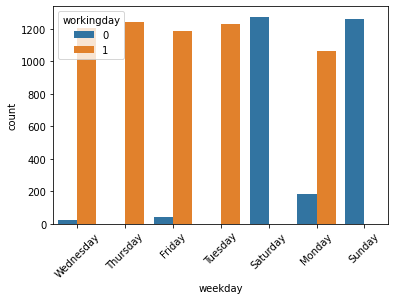

In [ ]:
sns.countplot(data = df_copy, x='weekday', hue = 'workingday')
plt.xticks(rotation = 45)

* As expected Weekdays are working days(1) and weekends are not(0)

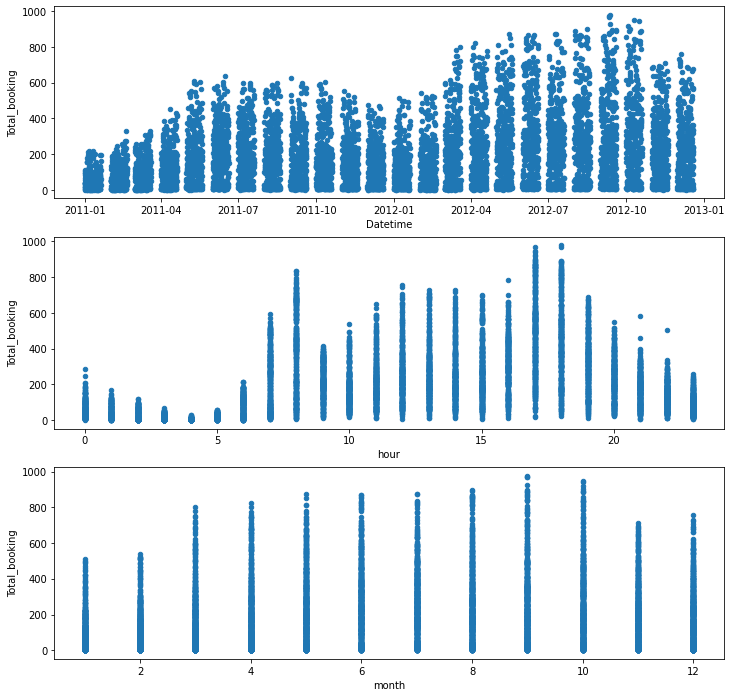

In [ ]:
# Comparing the affect of dates, hour and month on the 'Total_booking' column

fig,ax = plt.subplots(3,1,figsize= (12,12))
df.plot(x='Datetime', y='Total_booking', ax=ax[0],kind='scatter')
df.plot(x='hour', y='Total_booking', ax=ax[1],kind='scatter')

df.plot(x='month', y='Total_booking', ax=ax[2],kind='scatter')

* Insights
* -> We can see that total number of bookings are higher in the morning hours (7am to 8am) and again during the evening(5pm to 6pm) intervals
* -> This can be attributed to the office opening and closing hours 
* -> The total number of cab bookings on average have risen from the year 2011 to 2012, with them having highest number of cab bookings 
* -> during the 7th to 10th month of the year

In [ ]:
df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,Datetime,date,hour,weekday,month,day,year,humidity_block,temp_block,wind_block
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012-05-02 19:00:00,5/2/2012,19,Wednesday,5,2,2012,"(74.0, 81.0]","(17.22, 22.96]","(15.001, 16.998]"
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012-09-05 04:00:00,9/5/2012,4,Wednesday,9,5,2012,"(74.0, 81.0]","(27.88, 41.0]","(16.998, 19.001]"


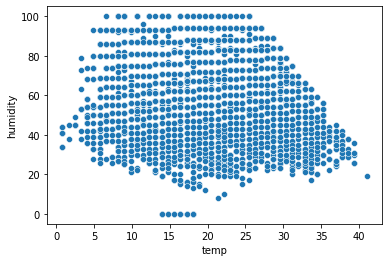

In [ ]:
# Temp vs humidaity scatter plot
sns.scatterplot(x='temp',y='humidity', data = df_copy)

* We see that as the temp goes higher than 27.5 degrees the humidity tends to decrease
* -> colder temp tend to have higher humidity

In [ ]:
df_copy.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month,day,year
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,5,2,2012
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,4,Wednesday,9,5,2012
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1/13/2011,9,Thursday,1,13,2011


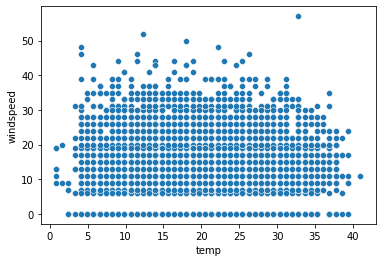

In [ ]:
# temp vs windspeed features
sns.scatterplot(x='temp',y='windspeed', data = df_copy)

* There is no significant pattern between windspeed with the temperature

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

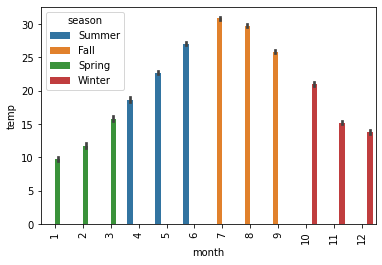

In [ ]:
# Month vs the temperature features
sns.barplot(x='month',y='temp', data = df_copy,hue='season')
plt.xticks(rotation=90)

* As expected the temperatures in higher during the 6th to 9th months (June to September)
* Gets cooler during the winter and spring seasons

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

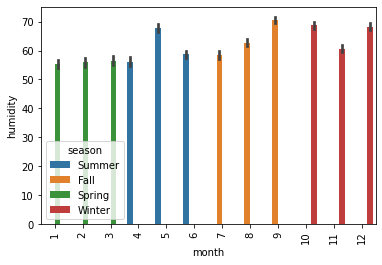

In [ ]:
# Month vs the humidity features hue season distribution
sns.barplot(y='humidity',x='month', data = df_copy, hue ='season')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

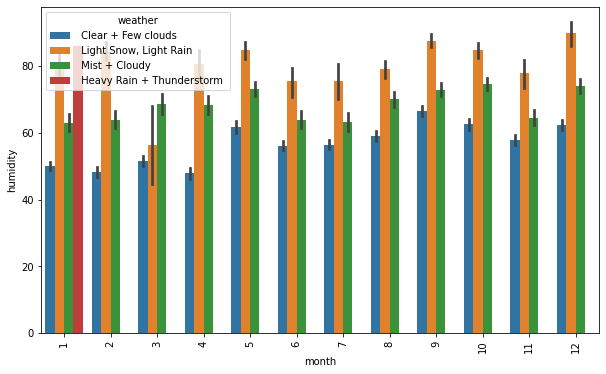

In [ ]:
# Month vs the humidity features hue weather conditions
plt.figure(figsize = (10,6))
sns.barplot(y='humidity',x='month', data = df_copy, hue ='weather')

plt.xticks(rotation=90)

* On average 'Light Snow, Light Rain' has higher humidity than other weather conditions.
* 'Clear + Few Clouds' has least humidity among the others

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

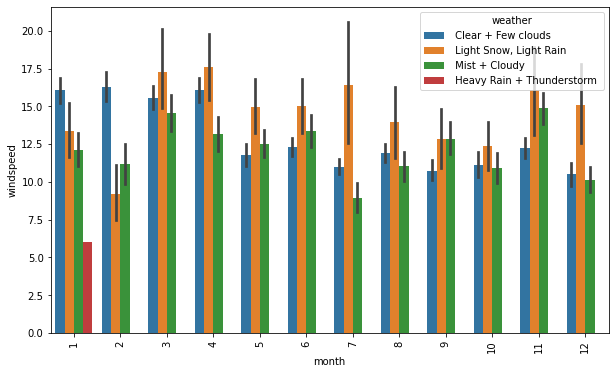

In [ ]:
# Month vs the windspeed features
plt.figure(figsize = (10,6))
sns.barplot(y='windspeed',x='month', data = df_copy, hue ='weather')

plt.xticks(rotation=90)

Insights - 
* Mist + Cloudy has the lowest windspeeds
* 'Clear + Few Clouds' and ' Light Snow, Light Rain' have higher windspeeds than the other weather conditions

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

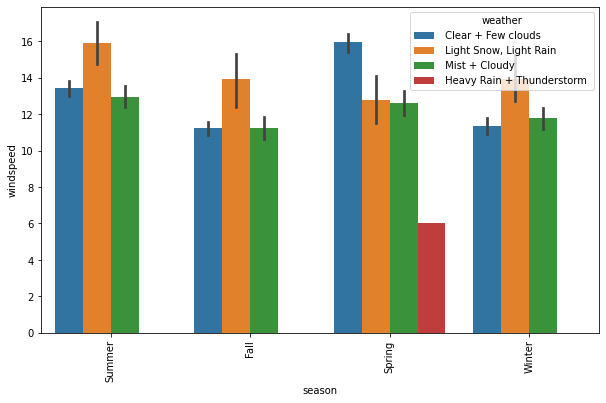

In [ ]:
# Season vs the windspeed features
plt.figure(figsize = (10,6))
sns.barplot(y='windspeed',x='season', data = df_copy, hue ='weather')

plt.xticks(rotation=90)

Insights - 
* On average 'Light Snow, Light Rain' has higher windspeeds during the Summer, Fall and winter Seasons


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

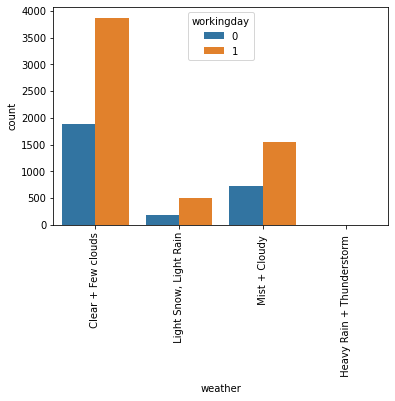

In [ ]:
#Count of different weather conditions.
sns.countplot(data = df_copy, x='weather', hue = 'workingday')
plt.xticks(rotation = 90)

* As we see Clear + Few Clouds have the highest number of occurences in our dataset. Heavy Rain + Thunderstorm has ~ 0 value counts

In [ ]:
df_copy.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month,day,year
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,5,2,2012
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,4,Wednesday,9,5,2012
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1/13/2011,9,Thursday,1,13,2011


##  Compare Total Booking Feature with other Features
## Visualizing Total_booking Vs other features to generate insights

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

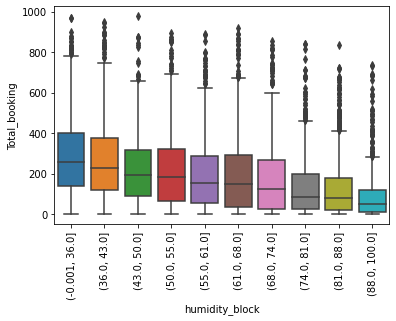

In [ ]:
sns.boxplot(x='humidity_block', y='Total_booking', data =df)
plt.xticks(rotation = 90)

* On avergage Total Booking of cabs decreases as the humidity increases

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

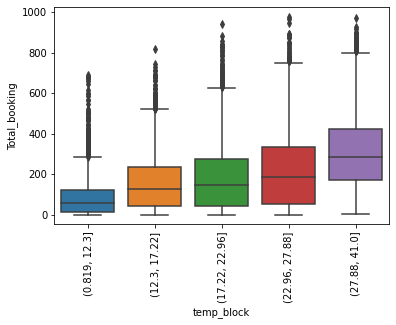

In [ ]:
sns.boxplot(x='temp_block', y='Total_booking', data =df)
plt.xticks(rotation = 90)

* On avergage Total Booking of cabs increases as the temperature increases

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

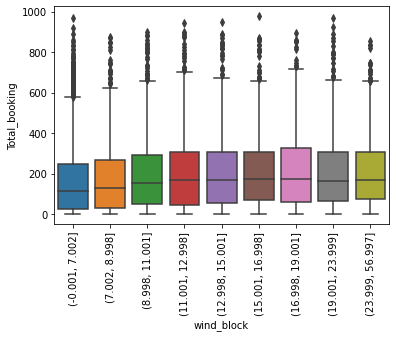

In [ ]:
sns.boxplot(x='wind_block', y='Total_booking', data =df)
plt.xticks(rotation = 90)

* There is no particularly visible correlation relationship between windspeed and total booking features

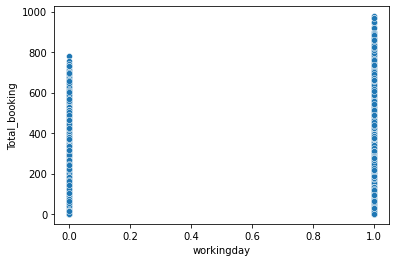

In [ ]:
s3 = sns.scatterplot(x='workingday',y='Total_booking', data = df_copy)

* At first look workingday = 1 has higher Total_booking records than workingday = 0 

In [ ]:
# sns.pairplot(df_copy,height = 5, width = 5)

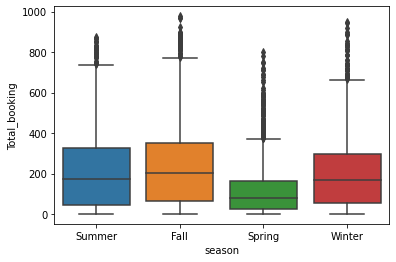

In [ ]:
sns.boxplot(x='season',y='Total_booking', data = df_copy)

* On average The fall season has higher number of cab bookings than the other seasons
* Spring season has the least number of bookings on average

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

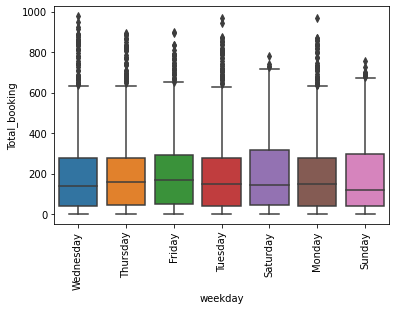

In [ ]:
sns.boxplot(x='weekday',y='Total_booking', data = df_copy)
plt.xticks(rotation = 90)

* No particular correlation between the week days and cab bookings as seen. But weekdays (Monday to Friday) seem to have a large number of outliers in the dataset

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

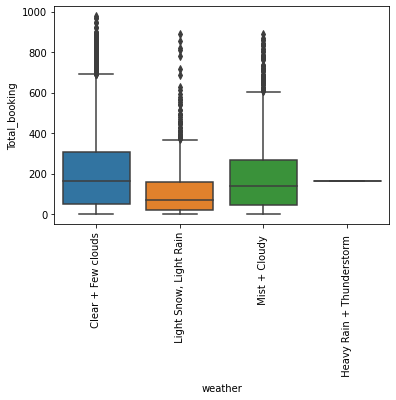

In [ ]:
sns.boxplot(x='weather',y='Total_booking', data = df_copy)
plt.xticks(rotation = 90)

* Only one entry is present for Heavy Rain + Thunderstorm weather condition

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

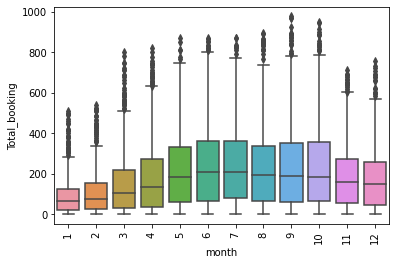

In [ ]:
sns.boxplot(x='month',y='Total_booking', data = df_copy)
plt.xticks(rotation = 90)

* On average the months 6-10 have comparitively higher number of cab bookings in the year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

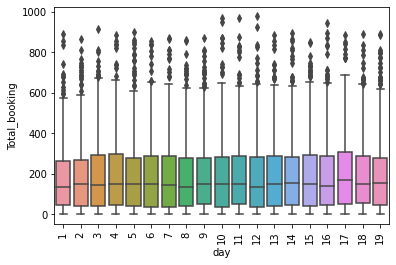

In [ ]:
sns.boxplot(x='day',y='Total_booking', data = df_copy)
plt.xticks(rotation = 90)

* No particular visible correlation between the day number of the month and total cab bookings

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

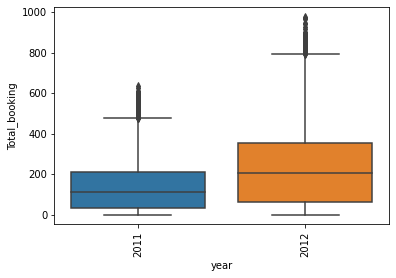

In [ ]:
sns.boxplot(x='year',y='Total_booking', data = df_copy)
plt.xticks(rotation = 90)

* As seen from the earlier visualizations, 2012 has higher number of average cab bookings, indicating the increase in cab demand per year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

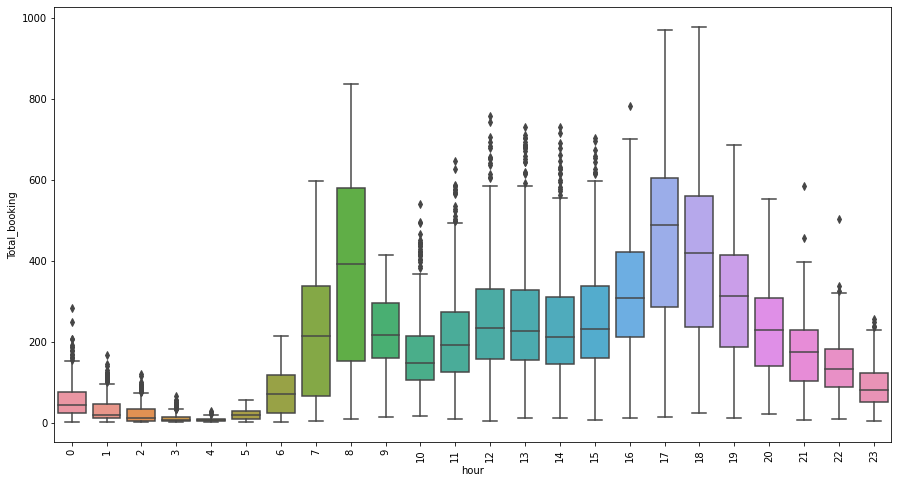

In [ ]:
plt.figure(figsize = (15,8))
sns.boxplot(x='hour',y='Total_booking', data = df_copy)

plt.xticks(rotation = 90)

* As expected **office** **opening** and **closing** hours have higher number of cab booking than the rest of the hours in a day.

## Outlier Analysis

In [ ]:
#Creating categorical feature mask
categorical_feature_mask = df_copy.dtypes == object

# Get list of categorical column names
categorical_columns = df_copy.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = df_copy.columns[~categorical_feature_mask].tolist()
outlier_analysis_columns = ['temp','atemp','humidity','windspeed']

In [ ]:
def remove_outlier(df_in):
  for i in df_in.columns:
    if i in outlier_analysis_columns:
      q1 = df_in[i].quantile(0.25)
      q3 = df_in[i].quantile(0.75)
      iqr = q3-q1 #Interquartile range
      fence_low  = q1-1.5*iqr
      fence_high = q3+1.5*iqr
      df_out = df_in.loc[(df_in[i] > fence_low) & (df_in[i] < fence_high)]

  return df_out


In [ ]:
outlier_analysis_columns
# These columns have numeric continuous data and are more prone to outliers

['temp', 'atemp', 'humidity', 'windspeed']

In [ ]:
categorical_columns

['season', 'weather', 'date', 'weekday']

In [ ]:
non_categorical_columns

['holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'Total_booking',
 'hour',
 'month',
 'day',
 'year']

In [ ]:
df_copy.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,Total_booking,hour,month,day,year
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,0.028480,0.680294,20.243020,23.655552,61.649173,12.843891,193.007005,11.581190,6.528709,10.009531,2011.505168
std,0.166348,0.466389,7.813494,8.501107,19.199578,8.190314,181.552211,6.890534,3.440879,5.480540,0.500002
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000
25%,0.000000,0.000000,13.940000,16.665000,46.000000,7.001500,43.000000,6.000000,4.000000,5.000000,2011.000000
50%,0.000000,1.000000,20.500000,24.240000,61.000000,12.998000,148.000000,12.000000,7.000000,10.000000,2012.000000
75%,0.000000,1.000000,26.240000,31.060000,77.000000,16.997900,286.000000,18.000000,10.000000,15.000000,2012.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,977.000000,23.000000,12.000000,19.000000,2012.000000


In [ ]:
df_copy.shape

(8708, 15)

### df_out11 -> training dataset with outlier analysis columns
### df_test_copy_out11 -> test dataset with outlier analysis columns

In [ ]:
# Seperating the columns for outlier analysis
df_out11 = df_copy[outlier_analysis_columns]
df_test_copy_out11 = df_test_copy[outlier_analysis_columns]

In [ ]:
df_out11.describe()

,temp,atemp,humidity,windspeed
count,8708.000000,8708.000000,8708.000000,8708.000000
mean,20.243020,23.655552,61.649173,12.843891
std,7.813494,8.501107,19.199578,8.190314
min,0.820000,0.760000,0.000000,0.000000
25%,13.940000,16.665000,46.000000,7.001500
50%,20.500000,24.240000,61.000000,12.998000
75%,26.240000,31.060000,77.000000,16.997900
max,41.000000,45.455000,100.000000,56.996900


In [ ]:
df_out11.shape, df_test_copy_out11.shape

((8708, 4), (2178, 4))

### **df_out1111** = Training data set filtered for outliers
### **df_test_copy_out1111** = Testing data set filtered for outliers

### Creating an outlier filter to filter outliers
* Assuming outlier = value with zscore less than 3 or greater than 3.
* x is not an outlier if zscore = -3 < x < zscore = +3

In [ ]:
df_out1111 =df_out11[(np.abs(stats.zscore(df_out11)) < 3).all(axis=1)]
df_test_copy_out1111 = df_test_copy_out11[(np.abs(stats.zscore(df_test_copy_out11)) < 3).all(axis=1)]

In [ ]:
df_out1111.shape,df_test_copy_out1111.shape

((8643, 4), (2152, 4))

In [ ]:
df_copy[['temp','atemp','humidity','windspeed']].describe()

,temp,atemp,humidity,windspeed
count,8708.000000,8708.000000,8708.000000,8708.000000
mean,20.243020,23.655552,61.649173,12.843891
std,7.813494,8.501107,19.199578,8.190314
min,0.820000,0.760000,0.000000,0.000000
25%,13.940000,16.665000,46.000000,7.001500
50%,20.500000,24.240000,61.000000,12.998000
75%,26.240000,31.060000,77.000000,16.997900
max,41.000000,45.455000,100.000000,56.996900


In [ ]:
df_out1111.describe()

,temp,atemp,humidity,windspeed
count,8643.000000,8643.000000,8643.000000,8643.000000
mean,20.270309,23.689180,61.858845,12.672636
std,7.816654,8.493366,18.955470,7.913751
min,0.820000,0.760000,8.000000,0.000000
25%,13.940000,16.665000,47.000000,7.001500
50%,20.500000,24.240000,62.000000,12.998000
75%,26.240000,31.060000,77.000000,16.997900
max,41.000000,45.455000,100.000000,36.997400


* As we see here we are able to remove the outliers according to our set range
* eg - max for windspeed and min for humidity

### Adding the outlier filtered dataset with original features that we left out *earlier*

In [ ]:
for i in df_copy.columns:
  if i not in df_out1111.columns:
    df_out1111[i]=df_copy[i]

for i in df_test_copy.columns:
  if i not in df_test_copy_out1111.columns:
    df_test_copy_out1111[i]=df_test_copy[i]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
df_out1111.shape, df_test_copy_out1111.shape

((8643, 15), (2152, 15))

### We know that workingday and holiday should reflect each other. That is, one should be opposite of another
* But as we see this is not the case in our dataset

In [ ]:
df_out1111[df_out1111['holiday']==df_out1111['workingday']].shape[0]

2519

In [ ]:
df_out1111.shape[0]

8643

In [ ]:
round(df_out1111[df_out1111['holiday']==df_out1111['workingday']].shape[0]/df_out1111.shape[0] * 100,2)

29.14

* ~30% of the columns in holiday column and workingday are not opposite. i.e. They are equal
* We cannot drop these 30% columns as they will affect the model performance
* Hence we will drop the holiday column.
* We will drop the column in the Correlation Analysis Section

In [ ]:
df_out1111.head(3)

,temp,atemp,humidity,windspeed,season,holiday,workingday,weather,Total_booking,date,hour,weekday,month,day,year
0,22.14,25.760,77,16.9979,Summer,0,1,Clear + Few clouds,504,5/2/2012,19,Wednesday,5,2,2012
1,28.70,33.335,79,19.0012,Fall,0,1,Clear + Few clouds,5,9/5/2012,4,Wednesday,9,5,2012
2,5.74,6.060,50,22.0028,Spring,0,1,Clear + Few clouds,139,1/13/2011,9,Thursday,1,13,2011


In [ ]:
df_test_copy_out1111.head(3)

,temp,atemp,humidity,windspeed,season,holiday,workingday,weather,Total_booking,date,hour,weekday,month,day,year
0,21.32,25.000,48,35.0008,Summer,0,1,Clear + Few clouds,256,5/10/2012,11,Thursday,5,10,2012
1,23.78,27.275,64,7.0015,Summer,0,0,Clear + Few clouds,87,6/9/2012,7,Saturday,6,9,2012
2,11.48,12.120,100,27.9993,Spring,0,0,"Light Snow, Light Rain",11,3/6/2011,20,Sunday,3,6,2011


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

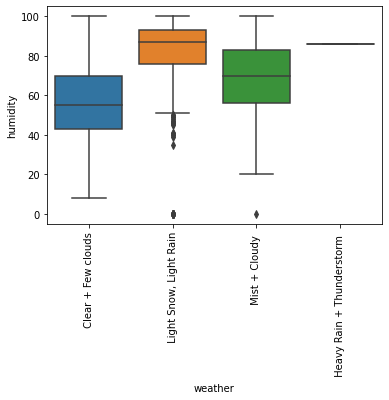

In [ ]:
sns.boxplot(x='weather',y='humidity',data = df_copy)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

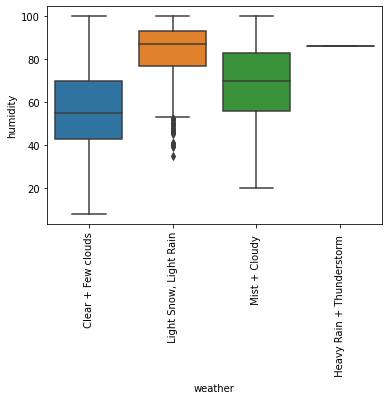

In [ ]:
sns.boxplot(x='weather',y='humidity',data = df_out1111)

plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

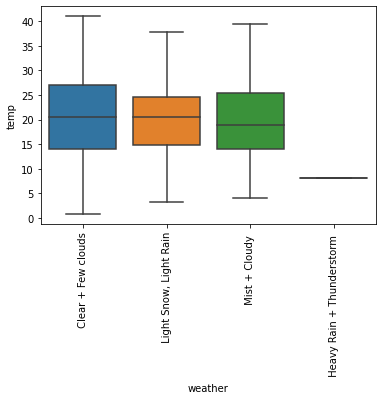

In [ ]:
sns.boxplot(x='weather',y='temp',data = df_copy)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

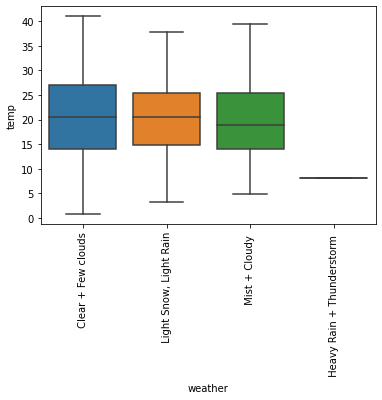

In [ ]:
sns.boxplot(x='weather',y='temp',data = df_out1111)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

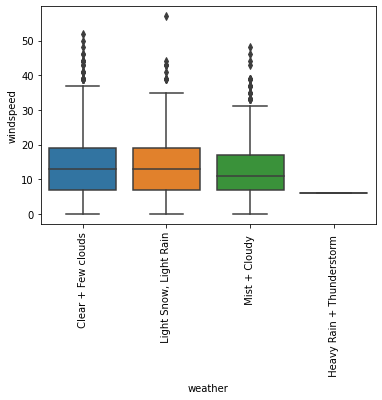

In [ ]:
sns.boxplot(x='weather',y='windspeed',data = df_copy)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

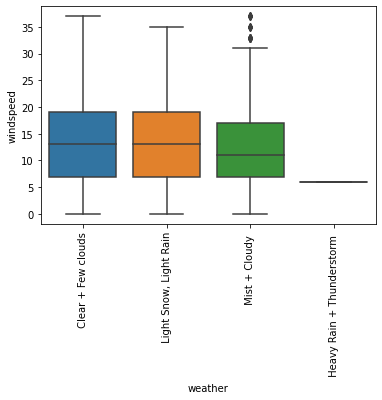

In [ ]:
sns.boxplot(x='weather',y='windspeed',data = df_out1111)
plt.xticks(rotation = 90)

### As we notice from the above displayed few examples. We were able to filter outliers from out dataset. These outliers could have affected our model and skewed our data if not treated.

## Correlation Analysis


In [ ]:
# We will create a correlation mask to create traingular correaltion plot
corr_matrix = df_out1111.corr()
mask = np.triu(np.ones_like(corr_matrix))

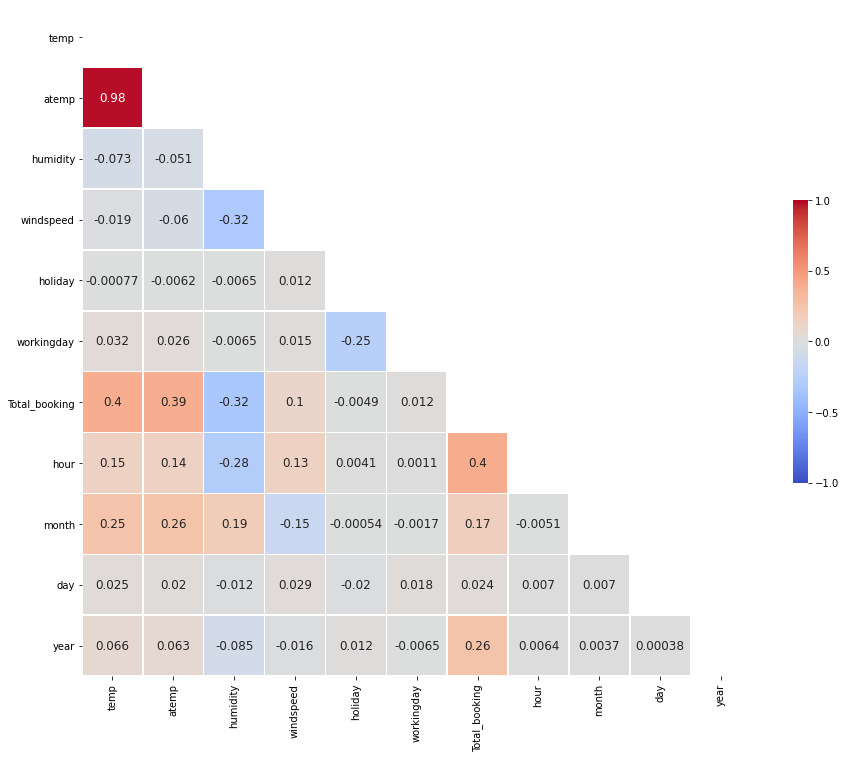

In [ ]:

f, ax = plt.subplots(figsize=(15, 13))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

* As we see **temp** and **atemp** column have a **very high correlation coefficeint** ~ 1.
* As both of these features have similar coefficients of correlation with other features, we can safely drop one of the columns
* We will drop the atemp column for in our model

## Feature Engineering Final



In [ ]:
df_dummies = pd.get_dummies(df_out1111.drop(['date','holiday','atemp'],axis =1),drop_first = True)
df_test_dummies = pd.get_dummies(df_test_copy_out1111.drop(['date','holiday','atemp'],axis =1), drop_first = True)

In [ ]:
df_dummies.head(3)

,temp,humidity,windspeed,workingday,Total_booking,hour,month,day,year,season_Spring,season_Summer,season_Winter,weather_ Heavy Rain + Thunderstorm,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,22.14,77,16.9979,1,504,19,5,2,2012,0,1,0,0,0,0,0,0,0,0,0,1
1,28.70,79,19.0012,1,5,4,9,5,2012,0,0,0,0,0,0,0,0,0,0,0,1
2,5.74,50,22.0028,1,139,9,1,13,2011,1,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_dummies.shape, df_test_dummies.shape

((8643, 21), (2152, 20))

* Here we notice that test data has one less column

In [ ]:
# We check weather column value counts
df_out1111['weather'].value_counts()

 Clear + Few clouds            5725
 Mist + Cloudy                 2266
 Light Snow, Light Rain         651
 Heavy Rain + Thunderstorm        1
Name: weather, dtype: int64

In [ ]:
df_test_copy_out1111['weather'].value_counts()

 Clear + Few clouds        1431
 Mist + Cloudy              550
 Light Snow, Light Rain     171
Name: weather, dtype: int64

* As we notice training data set has 1 entry for Heavy Rain + Thunderstorm weather condition.
* Test dataset has 0 entries for Heavy Rain + Thunderstorm  weather condition
* Therefore we will drop the dummy column 'weather_ Heavy Rain + Thunderstorm' in training dataset to match the column shape as this wont have a large affect due to only 1 entry in this column being 1 and rest all are 0

In [ ]:
#drop 'weather_ Heavy Rain + Thunderstorm' column
df_dummies_w = df_dummies.drop('weather_ Heavy Rain + Thunderstorm ', axis= 1)

In [ ]:
df_dummies_w.shape, df_test_dummies.shape
#training and test dataset column shapes are equal

((8643, 20), (2152, 20))

In [ ]:
df_dummies_w.head(2)

,temp,humidity,windspeed,workingday,Total_booking,hour,month,day,year,season_Spring,season_Summer,season_Winter,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,22.14,77,16.9979,1,504,19,5,2,2012,0,1,0,0,0,0,0,0,0,0,1
1,28.70,79,19.0012,1,5,4,9,5,2012,0,0,0,0,0,0,0,0,0,0,1


# Regression Analysis

* Default scores for most regressor models is R^2



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
#train dataset -> drop target column
X = df_dummies_w.drop('Total_booking',axis =1)
y= df_dummies_w['Total_booking']

#test dataset -> drop target column
Xt = df_test_dummies.drop('Total_booking',axis =1)
yt= df_test_dummies['Total_booking']

In [ ]:
X.head(2)

,temp,humidity,windspeed,workingday,hour,month,day,year,season_Spring,season_Summer,season_Winter,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,22.14,77,16.9979,1,19,5,2,2012,0,1,0,0,0,0,0,0,0,0,1
1,28.70,79,19.0012,1,4,9,5,2012,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
y.head(2)

0    504
1      5
Name: Total_booking, dtype: int64

In [ ]:
X.shape,y.shape,Xt.shape,yt.shape

((8643, 19), (8643,), (2152, 19), (2152,))

## Linear Regressor

In [ ]:
linear_reg = LinearRegression()

In [ ]:
# Fitting training data to basic Linear Regressor

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, random_state =42)
linear_reg.fit(X_train,y_train)
print('Initial training score for Linear regressor:',linear_reg.score(X_train,y_train))

Initial training score for Linear regressor: 0.40199775302890817


In [ ]:
# We will scale the data
scaler = StandardScaler()
linear_reg = LinearRegression()
X_sca = scaler.fit_transform(X)
Xt_sca = scaler.fit_transform(Xt)
X_train,X_val,y_train,y_val = train_test_split(X_sca,y,test_size = 0.2, random_state =42)
linear_reg.fit(X_train,y_train)
print('Scaled validation data score for Linear regressor:',linear_reg.score(X_val,y_val))

Scaled validation data score for Linear regressor: 0.37970642254028575


In [ ]:
y_linear_pred = linear_reg.predict(X_val)
print(f'Linear Regressor validation RMSE score :{np.sqrt(mean_squared_error(y_val,y_linear_pred))}')
print(f'Linear Regressor validation MAE score :{mean_absolute_error(y_val,y_linear_pred)}')

Linear Regressor validation RMSE score :143.4226664138
Linear Regressor validation MAE score :108.0963188208152


### Lasso Regressor + GridSearchCV (Grid Search CV)

In [ ]:
lasso_reg = Lasso(alpha = 0.5)
lasso_param = {
    'alpha' : [0.5,0.7,1.0,1.5]
}

In [ ]:
lasso_grid = GridSearchCV(lasso_reg,lasso_param,cv= 5,n_jobs =-1)

In [ ]:
scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
Xt_sca = scaler.fit_transform(Xt)
X_train,X_val,y_train,y_val = train_test_split(X_sca,y,test_size = 0.2, random_state =42)
lasso_grid.fit(X_train,y_train)
print('Scaled validation data score for Lasso regressor:',lasso_grid.score(X_val,y_val))

Scaled validation data score for Lasso regressor: 0.3807155779914875


In [ ]:
lasso_grid.best_estimator_
# Best estimaot found by GridSearch

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso_grid.best_score_
#Best training score for lasso regressor

0.3972577039904417

In [ ]:
y_lasso_pred = lasso_grid.predict(X_val)
print(f'Lasso Regressor validation RMSE score :{np.sqrt(mean_squared_error(y_val,y_lasso_pred))}')
print(f'Lasso Regressor validation MAE score :{mean_absolute_error(y_val,y_lasso_pred)}')

Lasso Regressor validation RMSE score :143.30595177537884
Lasso Regressor validation MAE score :107.89690629277399


## Ridge Regressor + GridSearchCV (Grid Search CV)

In [ ]:
ridge_reg = Ridge()
ridge_param = {
    'alpha' : [0.5,0.7,1.0,1.5]
}

In [ ]:
ridge_grid = GridSearchCV(ridge_reg,ridge_param,cv= 5,n_jobs =-1)

In [ ]:
scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
Xt_sca = scaler.fit_transform(Xt)
X_train,X_val,y_train,y_val = train_test_split(X_sca,y,test_size = 0.2, random_state =42)
ridge_grid.fit(X_train,y_train)
print('Scaled validation data score for Ridge regressor:',ridge_grid.score(X_val,y_val))

Scaled validation data score for Ridge regressor: 0.37971856628032696


In [ ]:
ridge_grid.best_estimator_

Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge_grid.best_score_
#Best training score for lasso regressor

0.39779382258010443

In [ ]:
y_ridge_pred = ridge_grid.predict(X_val)
print(f'Ridge Regressor validation RMSE score :{np.sqrt(mean_squared_error(y_val,y_ridge_pred))}')
print(f'Ridge Regressor validation MAE score :{mean_absolute_error(y_val,y_ridge_pred)}')

Ridge Regressor validation RMSE score :143.421262484947
Ridge Regressor validation MAE score :108.09443121031505


## Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
svm_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, random_state =42)
svm_regr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
svm_regr.score(X_train, y_train)

0.2740372756382815

In [ ]:
print('Scaled validation data score for Support Vector regressor:',svm_regr.score(X_val,y_val))

Scaled validation data score for Support Vector regressor: 0.2478265612899545


## As we notice the scores for the Linear Regressor, Lasso and Ridge Regressor and SVR are quite low.
##->  **We will move to ensemble model regressors**

## Ensemble Random Forest Regressor


In [ ]:
rf =RandomForestRegressor()
scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
Xt_sca = scaler.fit_transform(Xt)
X_train,X_val,y_train,y_val = train_test_split(X_sca,y,test_size = 0.2, random_state =42)
rf.fit(X_train,y_train)
print("Random Forest Regressor training score :",rf.score(X_train,y_train))

Random Forest Regressor training score : 0.9919582721676865


In [ ]:
print("Random Forest Regressor validation score :",rf.score(X_val,y_val))

Random Forest Regressor validation score : 0.9457013279350861


In [ ]:
# Calculate RMSE and MAE for Random Forest Regressor
y_rf_pred = rf.predict(X_val)
print(f'Random Forest validation RMSE score :{np.sqrt(mean_squared_error(y_val,y_rf_pred))}')
print(f'Random Forest validation MAE score :{mean_absolute_error(y_val,y_rf_pred)}')

Random Forest validation RMSE score :42.43397873181521
Random Forest validation MAE score :26.559705031810292


### We will test this Random forest model on the test data now (Xt,yt)

In [ ]:
Xt_sca = scaler.fit_transform(Xt)
y_rf_test_pred = rf.predict(Xt_sca)
print(f'Random Forest test RMSE score :{np.sqrt(mean_squared_error(yt,y_rf_test_pred))}')
print(f'Random Forest test MAE score :{mean_absolute_error(yt,y_rf_test_pred)}')

Random Forest test RMSE score :39.658083345369235
Random Forest test MAE score :25.282806691449817


* The test accuracy is approx equal to the validation accuracy.
* Random Forest is a good model for our data set

## Ensemble - AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada_reg = AdaBoostRegressor( random_state=42,base_estimator=RandomForestRegressor())

In [ ]:
scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
Xt_sca = scaler.fit_transform(Xt)
X_train,X_val,y_train,y_val = train_test_split(X_sca,y,test_size = 0.2, random_state =42)
ada_reg.fit(X_train,y_train)
print("Adaboost Regressor training score :",ada_reg.score(X_train,y_train))

Adaboost Regressor training score : 0.9977880896195087


In [ ]:
print("Adaboost Regressor validation score :",ada_reg.score(X_val,y_val))

Adaboost Regressor validation score : 0.9482860169285018


In [ ]:
# Calculate RMSE and MAE for Random Forest Regressor
y_ada_pred = ada_reg.predict(X_val)
print(f'Adaboost Regressor validation RMSE score :{np.sqrt(mean_squared_error(y_val,y_ada_pred))}')
print(f'Adaboost Regressor validation MAE score :{mean_absolute_error(y_val,y_ada_pred)}')

Adaboost Regressor validation RMSE score :41.41170814150539
Adaboost Regressor validation MAE score :27.06362058993638


### We will test this AdaBoost Regressor model on the test data now (Xt,yt)

In [ ]:
Xt_sca = scaler.fit_transform(Xt)
y_ada_test_pred = ada_reg.predict(Xt_sca)
print(f'Adaboost Regressor test RMSE score :{np.sqrt(mean_squared_error(yt,y_ada_test_pred))}')
print(f'Adaboost Regressor test MAE score :{mean_absolute_error(yt,y_ada_test_pred)}')

Adaboost Regressor test RMSE score :38.115903475708365
Adaboost Regressor test MAE score :25.282639405204463


* We notice that Adaboost Regressor given slightly better performace than Random Forest Regressor on the training, validation and test scores(MSE,MAE,RMSE)
* This is expected as the Adaboost Regressor has base estimator as Random Forest Regressor which in itself is an ensemble regressor

## Ensemble- XGBoost Regressor + Grid Search CV

In [ ]:
steps = [
    ('scaler', StandardScaler()),
    ('reg',xgb.XGBRegressor(base_estimaotr = RandomForestRegressor()))]

param_grid = {
    'reg__n_estimators': range(50,500,50),
    'reg__learning_rate': [0.001,0.01,0.1,1]
}

In [ ]:
pipe = Pipeline(steps)

In [ ]:
g = GridSearchCV(pipe,param_grid, cv = 5, n_jobs = -1,verbose = 2)
g.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.7min finished


[15:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reg',
                                        XGBRegressor(base_estimaotr=RandomForestRegressor(bootstrap=True,
                                                                                          ccp_alpha=0.0,
                                                                                          criterion='mse',
                                                                                          max_depth=None,
                                                                                          max_features='auto',
                                                                              

In [ ]:
g.best_estimator_


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 XGBRegressor(base_estimaotr=RandomForestRegressor(bootstrap=True,
                                                                   ccp_alpha=0.0,
                                                                   criterion='mse',
                                                                   max_depth=None,
                                                                   max_features='auto',
                                                                   max_leaf_nodes=None,
                                                                   max_samples=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_s

In [ ]:
print("XGBoost Regressor training score :",g.score(X_train,y_train))

XGBoost Regressor training score : 0.9748375767851788


In [ ]:
print("XGBoost Regressor validation score :",g.score(X_val,y_val))

XGBoost Regressor validation score : 0.9322596418858172


In [ ]:
# XGBoost Predict on validation data
y_pred_xg = g.predict(X_val)

In [ ]:
print(f'XGBoost Regressor training RMSE score :{np.sqrt(mean_squared_error(y_train,g.predict(X_train)))}')

# Calculate RMSE and MAE for XGBoost Regressor

print(f'XGBoost Regressor validation RMSE score :{np.sqrt(mean_squared_error(y_val,y_pred_xg))}')
print(f'XGBoost Regressor validation MAE score :{mean_absolute_error(y_val,y_pred_xg)}')

XGBoost Regressor training RMSE score :28.812687910472796
XGBoost Regressor validation RMSE score :47.396131332600376
XGBoost Regressor validation MAE score :33.31445784629805


### We will test this XGBoost Regressor model on the test data now (Xt,yt)

In [ ]:
Xt_sca = scaler.fit_transform(Xt)
y_xg_test_pred = g.predict(Xt_sca)
print(f'XGBoost Regressor test RMSE score :{np.sqrt(mean_squared_error(yt,y_xg_test_pred))}')
print(f'XGBoost Regressor test MAE score :{mean_absolute_error(yt,y_xg_test_pred)}')

XGBoost Regressor test RMSE score :49.172300591075135
XGBoost Regressor test MAE score :34.84506285959183


# Final Conclusion
* As per the RMSE, MAE scores on the test data set **Adaboost Regressor** performs the best compared to Random Forest Regressor, XGBoost Regressor, Linear Regressor, Lasso and Ridge Regressor and SV Regressor.

# Hence we will choose the AdaBoost Regressor as our preferred model for the prediction of cab bookings.



---





